In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad, quadrature, quad

import sys

sys.path.append("../Codes/")
from Hall1997_symm import *
from Hall1997 import *

In [2]:
# converge strongly with order k: E[|X_T-Y_N|] <= C * dt^k, this concerns the convergence of the sample path
# converge weakly with order k: |E[g(X_T)]-E[g(Y_N)]| <= C * dt^k, this concerns the convergence of the distribution

In [3]:
class AngleModel(object):
    def __init__(self, mu=1, sigma=1) -> None:
        self.mu = mu
        self.sigma = sigma

    def drift_coeff(self, _X: float, _t: float) -> float:
        return self.mu

    def diffu_coeff(self, _X: float, _t: float) -> float:
        return self.sigma

    def dW(self, dt: float) -> float:
        return np.random.normal(loc=0.0, scale=np.sqrt(dt))

    def EulerMaruyama(self, init_cond, T, Nt=1000):
        # Euler-Maruyama scheme, strong order 0.5, weak order 1.0
        t0, X0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        X_grid = np.zeros(Nt + 1)
        X_grid[0] = X0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            X = X_grid[i - 1]
            X_grid[i] = (
                X + self.drift_coeff(X, t) * dt + self.diffu_coeff(X, t) * self.dW(dt)
            )
        return t_grid, X_grid

    def Milstein(self, init_cond, T, Nt=1000):
        # Milstein scheme, strong order 0.5, weak order 1.0
        t0, X0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        X_grid = np.zeros(Nt + 1)
        X_grid[0] = X0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            X = X_grid[i - 1]
            X_grid[i] = (
                X
                + self.drift_coeff(X, t) * dt
                + self.diffu_coeff(X, t) * self.dW(dt)
                + 0.5 * self.diffu_coeff(X, t) ** 2 * (self.dW(dt) ** 2 - dt)
            )
        return t_grid, X_grid

    def LeimkuhlerMatthews(self, init_cond, T, Nt=1000):
        t0, X0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        X_grid = np.zeros(Nt + 1)
        X_grid[0] = X0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            X = X_grid[i - 1]
            X_temp = (
                X
                + self.drift_coeff(X, t) * dt
                + 0.5 * self.diffu_coeff(X, t) * self.dW(dt)
            )
            X_grid[i] = X_temp + 0.5 * self.diffu_coeff(X, t) * self.dW(dt)
        return t_grid, X_grid

    def simulate_FPTD(self, init_cond, T, a, theta, dt=0.001, num=3000):
        # may use importance sampling to imporve...
        # upper and lower boundaries
        upper_bdy = lambda t: a - theta * t
        lower_bdy = lambda t: -a + theta * t
        # use Milstein scheme
        t0, X0 = init_cond
        upper_time, lower_time, vertical_x = [], [], []
        for n in range(num):
            
            # print(n, end=" ")
            
            X = X0
            for i in range(1, int((T-t0)/dt)+10):
                t = t0 + (i - 1) * dt
                X += (
                    self.drift_coeff(X, t) * dt
                    + self.diffu_coeff(X, t) * self.dW(dt)
                    + 0.5 * self.diffu_coeff(X, t) ** 2 * (self.dW(dt) ** 2 - dt)
                )
                if X >= upper_bdy(t):
                    upper_time.append(t)
                    break
                elif X <= lower_bdy(t):
                    lower_time.append(t)
                    break
                elif t>=T:
                    vertical_x.append(X)
                    break
        return np.array(upper_time), np.array(lower_time), np.array(vertical_x)

#### Test 1: symmetric case
#### take the maximum considered time $T$ to be the collapsing time, plot the two FPTD


In [4]:
# %%script echo skipping

mu = 1
sigma = 1
a = 1.5
theta = 0.3
T = a / theta

In [5]:
# %%script echo skipping

model = AngleModel(mu=mu, sigma=sigma)
num_sims = 10000
upper_time, lower_time, vertical_x = model.simulate_FPTD(init_cond=(0,0), T=T, a=a, theta=theta, dt=0.001, num=num_sims)

In [6]:
# %%script echo skipping

len(upper_time)/num_sims, len(lower_time)/num_sims, len(vertical_x)/num_sims

(0.9165, 0.0835, 0.0)

In [7]:
# %%script echo skipping

probu1_list = []
probu2_list = []
ts = np.linspace(0.01, T-0.01, 100)
for t in ts:
    probu1 = density_horiz_symm(t, mu=mu, a=a, b=theta, trunc_num=100, bdy="upper")
    probu2 = density_upper(t, mu=mu, a=a, b=theta, x0=0, trunc_num=100)
    probu1_list.append(probu1)
    probu2_list.append(probu2)

probl1_list = []
probl2_list = []
for t in ts:
    probl1 = density_horiz_symm(t, mu=mu, a=a, b=theta, trunc_num=100, bdy="lower")
    probl2 = density_lower(t, mu=mu, a=a, b=theta, x0=0, trunc_num=100)
    probl1_list.append(probl1)
    probl2_list.append(probl2)
    
counts_u, bins_u = np.histogram(upper_time, bins=40)
dt_u = bins_u[1] - bins_u[0]

counts_l, bins_l = np.histogram(lower_time, bins=40)
dt_l = bins_l[1] - bins_l[0]


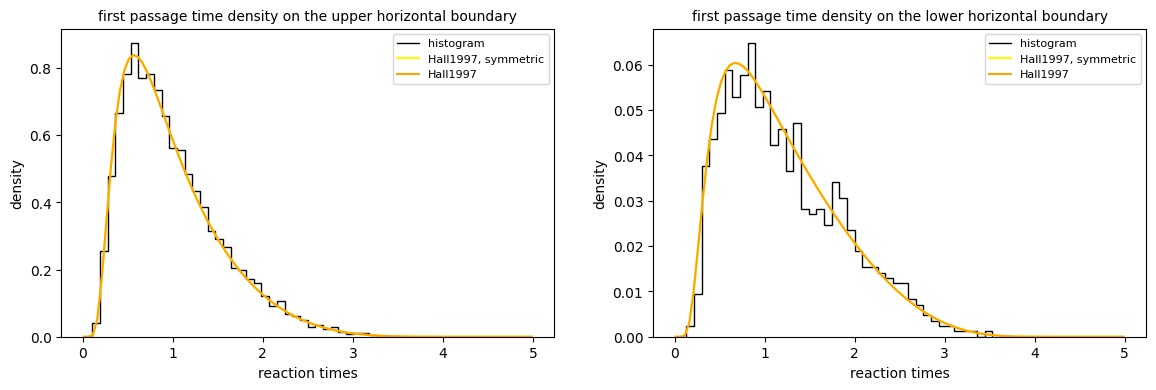

In [8]:
# %%script echo skipping

fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].stairs(counts_u / num_sims / dt_u, bins_u, color="black", label="histogram")
ax[0].plot(ts, probu1_list, label="Hall1997, symmetric", color="yellow")
ax[0].plot(ts, probu2_list, label="Hall1997", color="orange")
ax[0].legend(fontsize=8)
ax[0].set_title(
    "first passage time density on the upper horizontal boundary", fontsize=10
)
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")

ax[1].stairs(counts_l / num_sims / dt_l, bins_l, color="black", label="histogram")
ax[1].plot(ts, probl1_list, label="Hall1997, symmetric", color="yellow")
ax[1].plot(ts, probl2_list, label="Hall1997", color="orange")
ax[1].legend(fontsize=8)
ax[1].set_title(
    "first passage time density on the lower horizontal boundary", fontsize=10
)
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")

plt.show()

#### Test 2: symmetric case
#### take a small $T$, plot the three FPTD

In [9]:
mu = 1
sigma = 1
a = 1.5
theta = 0.3
T = 1

In [10]:
model = AngleModel(mu=mu, sigma=sigma)
num_sims = 20000
upper_time, lower_time, vertical_x = model.simulate_FPTD(init_cond=(0,0), T=T, a=a, theta=theta, dt=0.001, num=num_sims)

In [11]:
len(upper_time)/num_sims, len(lower_time)/num_sims, len(vertical_x)/num_sims

(0.54195, 0.03665, 0.4214)

In [12]:
probu1_list = []
probu2_list = []
ts = np.linspace(0.01, T - 0.01, 100)
for t in ts:
    probu1 = density_horiz_symm(t, mu=mu, a=a, b=theta, trunc_num=100, bdy="upper")
    probu2 = density_upper(t, mu=mu, a=a, b=theta, x0=0, trunc_num=100)
    probu1_list.append(probu1)
    probu2_list.append(probu2)
    
probl1_list = []
probl2_list = []
for t in ts:
    probl1 = density_horiz_symm(t, mu=mu, a=a, b=theta, trunc_num=100, bdy="lower")
    probl2 = density_lower(t, mu=mu, a=a, b=theta, x0=0, trunc_num=100)
    probl1_list.append(probl1)
    probl2_list.append(probl2)
    
probv1_list = []
probv2_list = []
xs = np.linspace(-a + theta * T, a - theta * T, 100)
for x in xs:
    probv1 = density_vertical_symm(x, mu=mu, a=a, b=theta, t0=T, trunc_num=100)
    probv2 = density_vertical(x, mu=mu, a=a, b=theta, x0=0, T=T, trunc_num=100)
    probv1_list.append(probv1)
    probv2_list.append(probv2)

counts_u, bins_u = np.histogram(upper_time, bins=40)
dt_u = bins_u[1] - bins_u[0]


counts_l, bins_l = np.histogram(lower_time, bins=40)
dt_l = bins_l[1] - bins_l[0]

counts_v, bins_v = np.histogram(vertical_x, bins=40)
dx_v = bins_v[1] - bins_v[0]


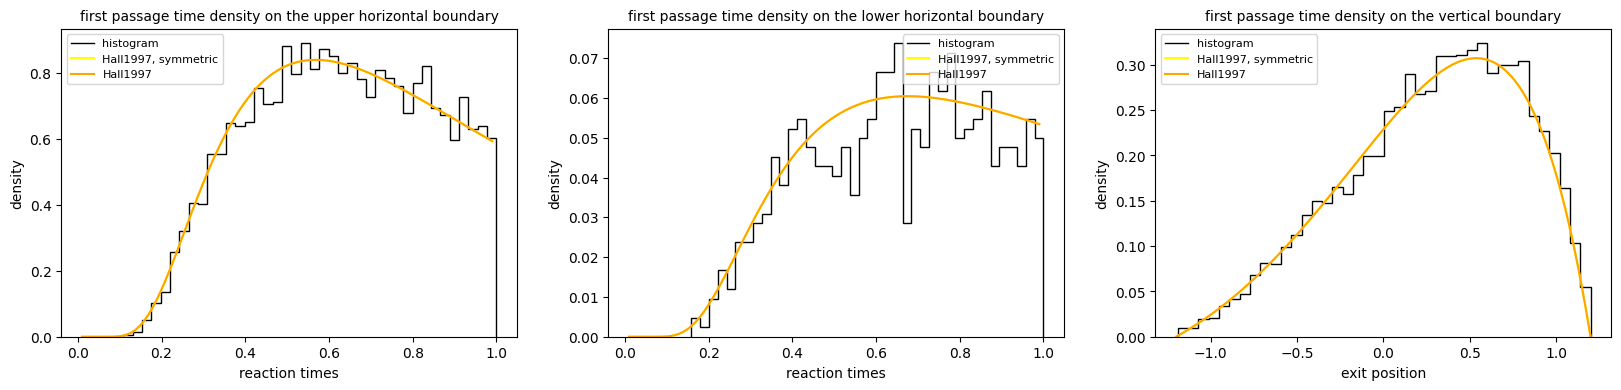

In [13]:

fig, ax = plt.subplots(1, 3, figsize=(20, 4), dpi=100)
ax[0].stairs(counts_u/num_sims/dt_u, bins_u, color="black", label="histogram")
ax[0].plot(ts, probu1_list, label="Hall1997, symmetric", color="yellow")
ax[0].plot(ts, probu2_list, label="Hall1997", color="orange")
ax[0].legend(fontsize=8)
ax[0].set_title("first passage time density on the upper horizontal boundary", fontsize=10)
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")

ax[1].stairs(counts_l/num_sims/dt_l, bins_l, color="black", label="histogram")
ax[1].plot(ts, probl1_list, label="Hall1997, symmetric", color="yellow")
ax[1].plot(ts, probl2_list, label="Hall1997", color="orange")
ax[1].legend(fontsize=8)
ax[1].set_title("first passage time density on the lower horizontal boundary", fontsize=10)
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")

ax[2].stairs(counts_v/num_sims/dx_v, bins_v, color="black", label="histogram")
ax[2].plot(xs, probv1_list, label="Hall1997, symmetric", color="yellow")
ax[2].plot(xs, probv2_list, label="Hall1997", color="orange")
ax[2].legend(fontsize=8)
ax[2].set_title("first passage time density on the vertical boundary", fontsize=10)
ax[2].set_xlabel("exit position")
ax[2].set_ylabel("density")

plt.show()

In [14]:
density_upper_eval = lambda t: density_horiz_symm(t, mu=mu, a=a, b=theta, trunc_num=50, bdy="upper")
density_lower_eval = lambda t: density_horiz_symm(t, mu=mu, a=a, b=theta, trunc_num=50, bdy="lower")
density_verti_eval = lambda x: density_vertical_symm(x, mu=mu, a=a, b=theta, t0=T, trunc_num=35)

In [15]:
Pu, _ = fixed_quad(density_upper_eval, 0, T, n=10)
Pl, _ = fixed_quad(density_lower_eval, 0, T, n=10)
Pv, _ = fixed_quad(density_verti_eval, -a + theta * T, a - theta * T, n=10)
Pu, Pl, Pv, Pu + Pl + Pv

(0.5467664851268483,
 0.039831357569581956,
 0.413328097014037,
 0.9999259397104674)

In [16]:
Pu, _ = quadrature(density_upper_eval, 0, T)
Pl, _ = quadrature(density_lower_eval, 0, T)
Pv, _ = quadrature(density_verti_eval, -a + theta * T, a - theta * T)
Pu, Pl, Pv, Pu + Pl + Pv

(0.5468368353855536,
 0.03983503297704253,
 0.4133280969973517,
 0.9999999653599478)

#### Test 3: asymmetric case
#### take a small $T$, plot the three FPTD

In [17]:
mu = 1
sigma = 1
a = 1.5
theta = 0.3
x0 = -0.3
T = 2

In [18]:
model = AngleModel(mu=mu, sigma=sigma)
num_sims = 20000
upper_time, lower_time, vertical_x = model.simulate_FPTD(init_cond=(0,x0), T=T, a=a, theta=theta, dt=0.001, num=num_sims)

In [19]:
len(upper_time)/num_sims, len(lower_time)/num_sims, len(vertical_x)/num_sims

(0.77965, 0.1318, 0.08855)

In [20]:
probu2_list = []
ts = np.linspace(0.01, T - 0.01, 100)
for t in ts:
    probu2 = density_upper(t, mu=mu, a=a, b=theta, x0=x0, trunc_num=100)
    probu2_list.append(probu2)
    
probl2_list = []
for t in ts:
    probl2 = density_lower(t, mu=mu, a=a, b=theta, x0=x0, trunc_num=100)
    probl2_list.append(probl2)
    
probv2_list = []
xs = np.linspace(-a + theta * T, a - theta * T, 100)
for x in xs:
    probv2 = density_vertical(x, mu=mu, a=a, b=theta, x0=x0, T=T, trunc_num=100)
    probv2_list.append(probv2)

counts_u, bins_u = np.histogram(upper_time, bins=40)
dt_u = bins_u[1] - bins_u[0]


counts_l, bins_l = np.histogram(lower_time, bins=40)
dt_l = bins_l[1] - bins_l[0]

counts_v, bins_v = np.histogram(vertical_x, bins=40)
dx_v = bins_v[1] - bins_v[0]

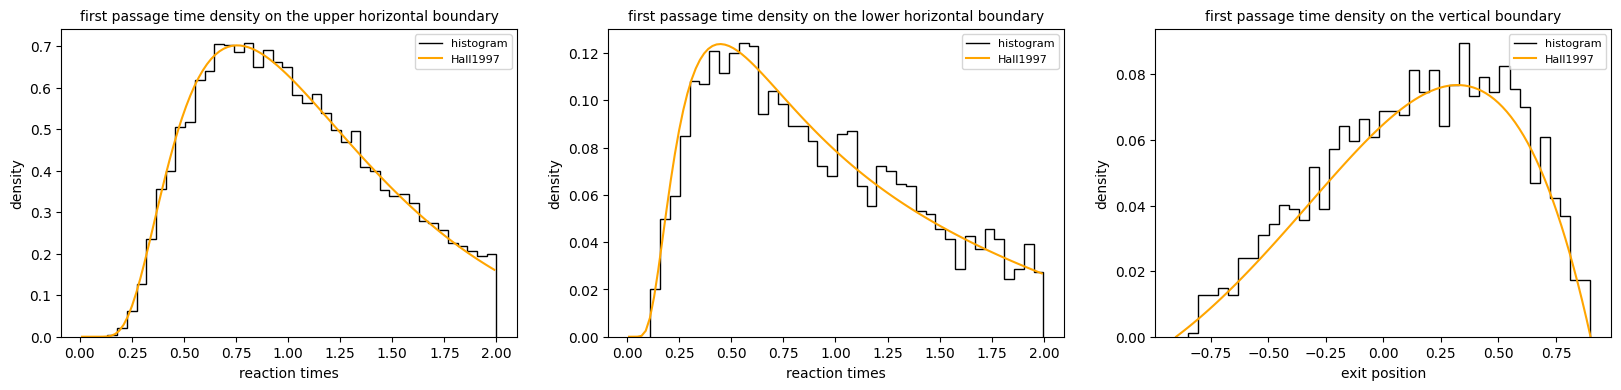

In [21]:

fig, ax = plt.subplots(1, 3, figsize=(20, 4), dpi=100)
ax[0].stairs(counts_u/num_sims/dt_u, bins_u, color="black", label="histogram")
ax[0].plot(ts, probu2_list, label="Hall1997", color="orange")
ax[0].legend(fontsize=8)
ax[0].set_title("first passage time density on the upper horizontal boundary", fontsize=10)
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")

ax[1].stairs(counts_l/num_sims/dt_l, bins_l, color="black", label="histogram")
ax[1].plot(ts, probl2_list, label="Hall1997", color="orange")
ax[1].legend(fontsize=8)
ax[1].set_title("first passage time density on the lower horizontal boundary", fontsize=10)
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")

ax[2].stairs(counts_v/num_sims/dx_v, bins_v, color="black", label="histogram")
ax[2].plot(xs, probv2_list, label="Hall1997", color="orange")
ax[2].legend(fontsize=8)
ax[2].set_title("first passage time density on the vertical boundary", fontsize=10)
ax[2].set_xlabel("exit position")
ax[2].set_ylabel("density")

plt.show()

In [22]:
density_upper_eval = lambda t: density_upper(t, mu=mu, a=a, b=theta, x0=x0, trunc_num=50)
density_lower_eval = lambda t: density_lower(t, mu=mu, a=a, b=theta, x0=x0, trunc_num=50)
density_verti_eval = lambda x: density_vertical(x, mu=mu, a=a, b=theta, x0=x0, T=T, trunc_num=35, if_logsumexp=False)
Pu, _ = fixed_quad(density_upper_eval, 0, T, n=10)
Pl, _ = fixed_quad(density_lower_eval, 0, T, n=10)
Pv, _ = fixed_quad(density_verti_eval, -a + theta * T, a - theta * T, n=10)
Pu, Pl, Pv, Pu + Pl + Pv

(0.7829536374052865,
 0.13475134803736344,
 0.08227624770326893,
 0.9999812331459188)